In [1]:
from typing import Literal
from langchain_core.prompts import ChatPromptTemplate
from langchain_groq import ChatGroq
from langchain_ollama.chat_models import ChatOllama
from pydantic import BaseModel, Field
from langchain_chroma import Chroma
from langchain_core.output_parsers import StrOutputParser
from langchain_ollama import OllamaEmbeddings
import chromadb
import pandas as pd
from pprint import pprint
from IPython.display import Image, display
import requests

In [2]:
llm = ChatGroq(temperature=0, model_name= "llama-3.1-70b-versatile")
sql_llm = ChatGroq(model_name= "llama-3.1-70b-versatile")    

# llm = ChatOllama(temperature=0, base_url="http://localhost:11434", model="llama3.2:latest")
# sql_llm = ChatOllama(base_url="http://localhost:11434", model="llama3.2:latest")

### 올라마 도커 기동
db_path = "./db/chroma_db_02"
vectorstore = Chroma(collection_name="collection_01", persist_directory=db_path, embedding_function=OllamaEmbeddings(base_url="http://localhost:11434", model="bge-m3:latest"))

## Helper Function

In [3]:
def get_semantic_search_docs(query:str, vectorstore, k:int=100, fetch_k:int=200):
    retriever = vectorstore.as_retriever(
        search_type="mmr", 
        search_kwargs={'k': k, "fetch_k": fetch_k}
        )
    result = retriever.invoke(query)
    return result

import re
import numpy as np
from rank_bm25 import BM25Okapi

def get_bm25_top_docs(query:str, documents:list, top_k:int=20):

    tokenized_corpus = [doc.page_content for doc in documents]
    bm25 = BM25Okapi(tokenized_corpus)

    pattern = r'`(.*?)`'  # 백틱으로 둘러싸인 단어만 검색 대상으로 리스트에 담기
    extracted_keywords = re.findall(pattern, query)

    doc_scores = bm25.get_scores(extracted_keywords)
    sorted_indices = np.argsort(doc_scores)  # 값에 대한 정렬된 인덱스
    order_values = np.empty_like(sorted_indices)
    order_values[sorted_indices] = np.arange(len(doc_scores))

    top_index = [i for i, value in enumerate(order_values) if value < top_k]
    top_docs = [i for i in documents if documents.index(i) in top_index ]
    return top_docs
    

def get_keywords_matched_docs(query:str, documents:list, and_condition:bool=True):
    pattern = r'`(.*?)`'  # 백틱으로 둘러싸인 단어만 검색 대상으로 리스트에 담기
    extracted_keywords = re.findall(pattern, query)
    lower_keywors = [keyword.lower() for keyword in extracted_keywords]

    lower_docs = [doc.page_content.lower() for doc in documents]
    if and_condition: matching_sentences = [sentence for sentence in lower_docs if all(keyword in sentence for keyword in lower_keywors)]
    else: matching_sentences = [sentence for sentence in lower_docs if any(keyword in sentence for keyword in lower_keywors)]

    matched_index = [lower_docs.index(doc) for doc in matching_sentences]
    final_matched_docs = [documents[i] for i in matched_index]

    return final_matched_docs


In [4]:
def vectordb_targets(db_path:str):
    client = chromadb.PersistentClient(path=db_path)
    for collection in client.list_collections():
        data = collection.get(include=['metadatas'])
    lv1 = list(set([d['First Division'] for d in data["metadatas"]]))
    print(lv1)
    lv2 = list(set([d['Second Division'] for d in data["metadatas"]]))
    print(lv2)
    rag_target = lv1 + lv2
    rag_target.insert(0, "vectorstore")
    rag_target.insert(0, "vectordb")
    docs = ", ".join(rag_target)
    return docs

docs = vectordb_targets(db_path=db_path)
docs

['MANUAL', 'PORT', 'Rules']
['Common', 'MARPOL', 'LR', 'ABS', 'Cryostar', 'BV', 'Port Regulation', 'Win GD', 'NK', 'Integrated Smart Ship(ISS)', 'KR', 'DNV', 'SOLAS']


'vectordb, vectorstore, MANUAL, PORT, Rules, Common, MARPOL, LR, ABS, Cryostar, BV, Port Regulation, Win GD, NK, Integrated Smart Ship(ISS), KR, DNV, SOLAS'

## Router

In [5]:
# Data model for Structured LLM
class RouteQuery(BaseModel):
    """Route a user query to the most relevant datasource."""

    datasource: Literal["similarity_search", "vectorstore", "web_search", "database"] = Field(
        ...,
        description="Given a user question choose to route it to web search or a vectorstore or a similarity or a database.",
    )

# Prompt
system = f"""You are an expert at routing a user question to a vectorstore, web search or database.
The vectorstore contains documents related to {docs}, Use the vectorstore for questions on these topics. 
The question contains words of similarity or sim search, Use similarity_search for the question.
The question contains words related to database, Use the database for the question. 
Otherwise, use web-search."""
route_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system),
        ("human", "{question}"),
    ]
)
structured_llm_router = llm.with_structured_output(RouteQuery)
question_router = route_prompt | structured_llm_router
question_router

ChatPromptTemplate(input_variables=['question'], input_types={}, partial_variables={}, messages=[SystemMessagePromptTemplate(prompt=PromptTemplate(input_variables=[], input_types={}, partial_variables={}, template='You are an expert at routing a user question to a vectorstore, web search or database.\nThe vectorstore contains documents related to vectordb, vectorstore, MANUAL, PORT, Rules, Common, MARPOL, LR, ABS, Cryostar, BV, Port Regulation, Win GD, NK, Integrated Smart Ship(ISS), KR, DNV, SOLAS, Use the vectorstore for questions on these topics. \nThe question contains words of similarity or sim search, Use similarity_search for the question.\nThe question contains words related to database, Use the database for the question. \nOtherwise, use web-search.'), additional_kwargs={}), HumanMessagePromptTemplate(prompt=PromptTemplate(input_variables=['question'], input_types={}, partial_variables={}, template='{question}'), additional_kwargs={})])
| RunnableBinding(bound=ChatGroq(client=

In [6]:
print(question_router.invoke({"question": "who is Son Heung-min"}))
print(question_router.invoke({"question": "according to database, who is Son Heung-min"}))
print(question_router.invoke({"question": "according to vectorstore, who is Son Heung-min"}))
print(question_router.invoke({"question": "sim search for Son Heung-min"}))

datasource='web_search'
datasource='database'
datasource='vectorstore'
datasource='similarity_search'


## Retrieval Grader

In [7]:
# Data model
class GradeDocuments(BaseModel):
    """Binary score for relevance check on retrieved documents."""

    binary_score: str = Field(
        description="Documents are relevant to the question, 'yes' or 'no'"
    )

# Prompt
system = """You are a grader assessing relevance of a retrieved document to a user question. \n 
    If the document contains keyword(s) or semantic meaning related to the user question, grade it as relevant. \n
    It does not need to be a stringent test. The goal is to filter out erroneous retrievals. \n
    Give a binary score 'yes' or 'no' score to indicate whether the document is relevant to the question."""
grade_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system),
        ("human", "Retrieved document: \n\n {document} \n\n User question: {question}"),
    ]
)
structured_llm_grader = llm.with_structured_output(GradeDocuments)
retrieval_grader = grade_prompt | structured_llm_grader
retrieval_grader

ChatPromptTemplate(input_variables=['document', 'question'], input_types={}, partial_variables={}, messages=[SystemMessagePromptTemplate(prompt=PromptTemplate(input_variables=[], input_types={}, partial_variables={}, template="You are a grader assessing relevance of a retrieved document to a user question. \n \n    If the document contains keyword(s) or semantic meaning related to the user question, grade it as relevant. \n\n    It does not need to be a stringent test. The goal is to filter out erroneous retrievals. \n\n    Give a binary score 'yes' or 'no' score to indicate whether the document is relevant to the question."), additional_kwargs={}), HumanMessagePromptTemplate(prompt=PromptTemplate(input_variables=['document', 'question'], input_types={}, partial_variables={}, template='Retrieved document: \n\n {document} \n\n User question: {question}'), additional_kwargs={})])
| RunnableBinding(bound=ChatGroq(client=<groq.resources.chat.completions.Completions object at 0x000001D37CB2

## Generate

In [8]:
# Prompt   (rlm/rag-prompt)
prompt = ChatPromptTemplate.from_messages([
    ("human", 
    """You are a smart AI assistant. 
    Use the following pieces of retrieved context to answer the question. 
    Generate detailed answer including specified numbers, fomulas in the point of technical specifications. 
    If you don't know the answer, just say that you don't know. 
    Question: {question} 
    Context: {context} 
    Answer:"""),
    ])

rag_chain = prompt | llm | StrOutputParser()
rag_chain


ChatPromptTemplate(input_variables=['context', 'question'], input_types={}, partial_variables={}, messages=[HumanMessagePromptTemplate(prompt=PromptTemplate(input_variables=['context', 'question'], input_types={}, partial_variables={}, template="You are a smart AI assistant. \n    Use the following pieces of retrieved context to answer the question. \n    Generate detailed answer including specified numbers, fomulas in the point of technical specifications. \n    If you don't know the answer, just say that you don't know. \n    Question: {question} \n    Context: {context} \n    Answer:"), additional_kwargs={})])
| ChatGroq(client=<groq.resources.chat.completions.Completions object at 0x000001D37CB22030>, async_client=<groq.resources.chat.completions.AsyncCompletions object at 0x000001D37D1EC050>, model_name='llama-3.1-70b-versatile', temperature=1e-08, model_kwargs={}, groq_api_key=SecretStr('**********'))
| StrOutputParser()

## Hallucination Grader

In [9]:
# Data model
class GradeHallucinations(BaseModel):
    """Binary score for hallucination present in generation answer."""

    binary_score: str = Field(
        description="Answer is grounded in the facts, 'yes' or 'no'"
    )

# Prompt
system = """You are a grader assessing whether an LLM generation is grounded in / supported by a set of retrieved facts. \n 
     Give a binary score 'yes' or 'no'. 'Yes' means that the answer is grounded in / supported by the set of facts."""
hallucination_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system),
        ("human", "Set of facts: \n\n {documents} \n\n LLM generation: {generation}"),
    ]
)
structured_llm_grader = llm.with_structured_output(GradeHallucinations)
hallucination_grader = hallucination_prompt | structured_llm_grader
hallucination_grader

ChatPromptTemplate(input_variables=['documents', 'generation'], input_types={}, partial_variables={}, messages=[SystemMessagePromptTemplate(prompt=PromptTemplate(input_variables=[], input_types={}, partial_variables={}, template="You are a grader assessing whether an LLM generation is grounded in / supported by a set of retrieved facts. \n \n     Give a binary score 'yes' or 'no'. 'Yes' means that the answer is grounded in / supported by the set of facts."), additional_kwargs={}), HumanMessagePromptTemplate(prompt=PromptTemplate(input_variables=['documents', 'generation'], input_types={}, partial_variables={}, template='Set of facts: \n\n {documents} \n\n LLM generation: {generation}'), additional_kwargs={})])
| RunnableBinding(bound=ChatGroq(client=<groq.resources.chat.completions.Completions object at 0x000001D37CB22030>, async_client=<groq.resources.chat.completions.AsyncCompletions object at 0x000001D37D1EC050>, model_name='llama-3.1-70b-versatile', temperature=1e-08, model_kwargs=

## Answer Grader

In [10]:
# Data model
class GradeAnswer(BaseModel):
    """Binary score to assess answer addresses question."""
    binary_score: str = Field(
        description="Answer addresses the question, 'yes' or 'no'"
    )

# Prompt
system = """You are a grader assessing whether an answer addresses / resolves a question \n 
     Give a binary score 'yes' or 'no'. Yes' means that the answer resolves the question."""
answer_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system),
        ("human", "User question: \n\n {question} \n\n LLM generation: {generation}"),
    ]
)
structured_llm_grader = llm.with_structured_output(GradeAnswer)
answer_grader = answer_prompt | structured_llm_grader
answer_grader

ChatPromptTemplate(input_variables=['generation', 'question'], input_types={}, partial_variables={}, messages=[SystemMessagePromptTemplate(prompt=PromptTemplate(input_variables=[], input_types={}, partial_variables={}, template="You are a grader assessing whether an answer addresses / resolves a question \n \n     Give a binary score 'yes' or 'no'. Yes' means that the answer resolves the question."), additional_kwargs={}), HumanMessagePromptTemplate(prompt=PromptTemplate(input_variables=['generation', 'question'], input_types={}, partial_variables={}, template='User question: \n\n {question} \n\n LLM generation: {generation}'), additional_kwargs={})])
| RunnableBinding(bound=ChatGroq(client=<groq.resources.chat.completions.Completions object at 0x000001D37CB22030>, async_client=<groq.resources.chat.completions.AsyncCompletions object at 0x000001D37D1EC050>, model_name='llama-3.1-70b-versatile', temperature=1e-08, model_kwargs={}, groq_api_key=SecretStr('**********')), kwargs={'tools': 

## Question Re-Writer

In [11]:
# Prompt
system = """You a question re-writer that converts an input question to a better version that is optimized \n 
     for vectorstore retrieval. Look at the input and try to reason about the underlying semantic intent / meaning."""
re_write_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system),
        (
            "human",
            "Here is the initial question: \n\n {question} \n Formulate an improved question.",
        ),
    ]
)
%timeit
question_rewriter = re_write_prompt | llm | StrOutputParser()
question_rewriter

ChatPromptTemplate(input_variables=['question'], input_types={}, partial_variables={}, messages=[SystemMessagePromptTemplate(prompt=PromptTemplate(input_variables=[], input_types={}, partial_variables={}, template='You a question re-writer that converts an input question to a better version that is optimized \n \n     for vectorstore retrieval. Look at the input and try to reason about the underlying semantic intent / meaning.'), additional_kwargs={}), HumanMessagePromptTemplate(prompt=PromptTemplate(input_variables=['question'], input_types={}, partial_variables={}, template='Here is the initial question: \n\n {question} \n Formulate an improved question.'), additional_kwargs={})])
| ChatGroq(client=<groq.resources.chat.completions.Completions object at 0x000001D37CB22030>, async_client=<groq.resources.chat.completions.AsyncCompletions object at 0x000001D37D1EC050>, model_name='llama-3.1-70b-versatile', temperature=1e-08, model_kwargs={}, groq_api_key=SecretStr('**********'))
| StrOut

## Web Search Tool

In [12]:
from langchain_community.tools.tavily_search import TavilySearchResults

web_search_tool = TavilySearchResults(k=3)
web_search_tool

TavilySearchResults(api_wrapper=TavilySearchAPIWrapper(tavily_api_key=SecretStr('**********')))

## Construct Graph

In [ ]:
from typing import List
from typing_extensions import TypedDict

class GraphState(TypedDict):
    """
    Represents the state of our graph.

    Attributes:
        connection: web connection
        question: question
        generation: LLM generation
        documents: list of documents
    """
    connection: bool = False
    question: str
    generation: str   
    documents: List[str]

    sql_query: str
    query_rows: list
    attempts: int
    relevance: str
    sql_error: bool

In [67]:
from langchain.schema import Document
from langchain_core.messages import RemoveMessage
from langchain_core.messages import AIMessage, HumanMessage

# Nodes

def similarity_search(state):
    """
    do hybrid similarity search

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): New key added to state, generation, that contains LLM generation

    """
    print("---Similarity Search---")
    question = state["question"]

    # Retrieval
    pattern = r'"(.*?)"'  # 따옴표로 둘러싸인 단어만 검색 대상으로 리스트에 담기
    extracted_keywords = re.findall(pattern, question)
    if len(extracted_keywords) > 0:
        documents = get_semantic_search_docs(query=question, vectorstore=vectorstore, k=100, fetch_k=500)
        print(len(documents))
        documents = get_bm25_top_docs(query=question, documents=documents, top_k=10)
        documents = get_keywords_matched_docs(query=question, documents=documents, and_condition=True)
        print(len(documents))
    else: documents = get_semantic_search_docs(query=question, vectorstore=vectorstore, k=3, fetch_k=500)
    
    return {"documents": documents, "question": question}

def sql_search(state):
    """
    Generate answer based on Databse

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): New key added to state, generation, that contains LLM generation

    """
    print("---SQL SEARCH---")
    question = state["question"]
    return {"documents": "Under Construction", "question": question, "generation": "Under Construction"}


def retrieve(state):
    """
    Retrieve documents

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): New key added to state, documents, that contains retrieved documents
    """
    print("---RETRIEVE---")
    question = state["question"]

    # Retrieval
    pattern = r'"(.*?)"'  # 따옴표로 둘러싸인 단어만 검색 대상으로 리스트에 담기
    extracted_keywords = re.findall(pattern, question)
    if len(extracted_keywords) > 0:
        documents = get_semantic_search_docs(query=question, vectorstore=vectorstore, k=100, fetch_k=500)
        documents = get_bm25_top_docs(query=question, documents=documents, top_k=10)
        documents = get_keywords_matched_docs(query=question, documents=documents, and_condition=True)
    else: documents = get_semantic_search_docs(query=question, vectorstore=vectorstore, k=3, fetch_k=500)
    
    return {"documents": documents, "question": question}


def generate(state):
    """
    Generate answer

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): New key added to state, generation, that contains LLM generation
    """
    print("---GENERATE---")
    question = state["question"]
    documents = state["documents"]

    # RAG generation
    generation = rag_chain.invoke({"context": documents, "question": question})
    return {"documents": documents, "question": question, "generation": generation}


def grade_documents(state):
    """
    Determines whether the retrieved documents are relevant to the question.

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): Updates documents key with only filtered relevant documents
    """

    print("---CHECK DOCUMENT RELEVANCE TO QUESTION---")
    question = state["question"]
    documents = state["documents"]

    # Score each doc
    try:
        print(f"Count of Retrieved Docs: {len(documents)}")
        filtered_docs = []
        for d in documents:
            score = retrieval_grader.invoke(
                {"question": question, "document": d.page_content}
            )
            grade = score.binary_score
            if grade == "yes":
                print("---GRADE: DOCUMENT RELEVANT---")
                filtered_docs.append(d)
            else:
                print("---GRADE: DOCUMENT NOT RELEVANT---")
                continue
        return {"documents": filtered_docs, "question": question}
    except Exception as e:
        print(f"Count of Retrieved Docs: {len(documents)}")
        print(e)


def transform_query(state):
    """
    Transform the query to produce a better question.

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): Updates question key with a re-phrased question
    """

    print("---TRANSFORM QUERY---")
    question = state["question"]
    documents = state["documents"]

    # Re-write question
    better_question = question_rewriter.invoke({"question": question})
    return {"documents": documents, "question": better_question}


def web_connection(state):
    print("---WEB CONNECTION---")
    print(f">>> state: {state}")
    res = check_internet(state)
    return {"connection": res}


def web_search(state):
    """
    Web search based on the re-phrased question.

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): Updates documents key with appended web results
    """

    print("---WEB SEARCH---")
    question = state["question"]

    # Web search
    docs = web_search_tool.invoke({"query": question})
    web_results = "\n".join([d["content"] for d in docs])
    web_results = Document(page_content=web_results)

    return {"documents": web_results, "question": question}


### Edges ###

def check_internet(state):
    """Check internet connection by pinging a website."""
    
    print("---CHECK INTERNET CONNECTION---")
    # question = state["question"]
    try:
        response = requests.get("https://www.google.com", timeout=2)
        # If the request is successful, we assume internet is ON
        if response.status_code == 200:
            # print("Internet is ON")
            return "ON"
    except requests.ConnectionError:
        # If there is a connection error, we assume internet is OFF
        # print("Internet is OFF")
        return "OFF"
    
    
def route_question(state):
    """
    Route question to web search or RAG.

    Args:
        state (dict): The current graph state

    Returns:
        str: Next node to call
    """

    print("---ROUTE QUESTION---")
    try:
        question = state["question"]
        source = question_router.invoke({"question": question})
        if source.datasource == "web_search":
            print("---ROUTE QUESTION TO WEB SEARCH---")
            return "web_search"
        elif source.datasource == "vectorstore":
            print("---ROUTE QUESTION TO RAG---")
            return "vectorstore"
        elif source.datasource == "similarity_search":
            print("---ROUTE QUESTION TO SIMILARITY SEARCH---")
            return "similarity_search"
        elif source.datasource == "database":
            print("---ROUTE QUESTION TO DATABASE---")
            return "database"
    except Exception as e:
        print(f"---ROUTING ERROR {e}---")
        return e


def decide_to_generate(state):
    """
    Determines whether to generate an answer, or re-generate a question.

    Args:
        state (dict): The current graph state

    Returns:
        str: Binary decision for next node to call
    """

    print("---ASSESS GRADED DOCUMENTS---")
    state["question"]
    filtered_documents = state["documents"]

    if not filtered_documents:
        # All documents have been filtered check_relevance
        # We will re-generate a new query
        print(
            "---DECISION: ALL DOCUMENTS ARE NOT RELEVANT TO QUESTION, TRANSFORM QUERY---"
        )
        return "transform_query"
    else:
        # We have relevant documents, so generate answer
        print("---DECISION: GENERATE---")
        return "generate"


def grade_generation_v_documents_and_question(state):
    """
    Determines whether the generation is grounded in the document and answers question.

    Args:
        state (dict): The current graph state

    Returns:
        str: Decision for next node to call
    """

    print("---CHECK HALLUCINATIONS---")
    question = state["question"]
    documents = state["documents"]
    generation = state["generation"]

    score = hallucination_grader.invoke(
        {"documents": documents, "generation": generation}
    )
    grade = score.binary_score

    # Check hallucination
    if grade == "yes":
        print("---DECISION: GENERATION IS GROUNDED IN DOCUMENTS---")
        # Check question-answering
        print("---GRADE GENERATION vs QUESTION---")
        score = answer_grader.invoke({"question": question, "generation": generation})
        grade = score.binary_score
        if grade == "yes":
            print("---DECISION(Useful): GENERATION ADDRESSES QUESTION---")
            return "useful"
        else:
            print("---DECISION(Not Useful): GENERATION DOES NOT ADDRESS QUESTION---")
            return "not useful"
    else:
        print("---DECISION(Not Supported): GENERATION IS NOT GROUNDED IN DOCUMENTS, RE-TRY---")
        return "not supported"

## SQL Agent Codes

In [ ]:
import os
from dotenv import load_dotenv
from sqlalchemy import create_engine, Column, Integer, String, ForeignKey, Float
from sqlalchemy.orm import sessionmaker, relationship, declarative_base
from langchain_core.runnables.config import RunnableConfig
from langchain_groq import ChatGroq

DATABASE_URL = os.getenv("DATABASE_URL", "sqlite:///./db/example.db")
engine = create_engine(DATABASE_URL)
SessionLocal = sessionmaker(autocommit=False, autoflush=False, bind=engine)
Base = declarative_base()
Base

In [ ]:
# Definition of the Users table
class User(Base):
    __tablename__ = "users"

    id = Column(Integer, primary_key=True, index=True)
    name = Column(String, index=True)
    age = Column(Integer)
    email = Column(String, unique=True, index=True)

    orders = relationship("Order", back_populates="user")

# Definition of the Food table
class Food(Base):
    __tablename__ = "food"

    id = Column(Integer, primary_key=True, index=True)
    name = Column(String, unique=True, index=True)
    price = Column(Float)

    orders = relationship("Order", back_populates="food")

# Definition of the Orders table
class Order(Base):
    __tablename__ = "orders"

    id = Column(Integer, primary_key=True, index=True)
    food_id = Column(Integer, ForeignKey("food.id"))
    user_id = Column(Integer, ForeignKey("users.id"))

    user = relationship("User", back_populates="orders")
    food = relationship("Food", back_populates="orders")

In [ ]:
import os
from dotenv import load_dotenv
from typing_extensions import TypedDict
from pydantic import BaseModel, Field

from langchain_core.prompts import ChatPromptTemplate
from langchain_core.output_parsers import StrOutputParser
from sqlalchemy import text, inspect
from langgraph.graph import StateGraph, START, END

In [ ]:
def get_database_schema(engine):
    inspector = inspect(engine)
    schema = ""
    for table_name in inspector.get_table_names():
        schema += f"Table: {table_name}\n"
        for column in inspector.get_columns(table_name):
            col_name = column["name"]
            col_type = str(column["type"])
            if column.get("primary_key"):
                col_type += ", Primary Key"
            if column.get("foreign_keys"):
                fk = list(column["foreign_keys"])[0]
                col_type += f", Foreign Key to {fk.column.table.name}.{fk.column.name}"
            schema += f"- {col_name}: {col_type}\n"
        schema += "\n"
    print("Retrieved database schema.")
    return schema

schema = get_database_schema(engine=engine)
print(schema)

In [ ]:
class CheckRelevance(BaseModel):
    relevance: str = Field(
        description="Indicates whether the question is related to the database schema. 'relevant' or 'not_relevant'."
    )

def check_relevance(state: GraphState, config: RunnableConfig):
    question = state["question"]
    schema = get_database_schema(engine)
    print(f"Checking relevance of the question: {question}")
    system = """You are an assistant that determines whether a given question is related to the following database schema.

Schema:
{schema}

Respond with only "relevant" or "not_relevant".
""".format(schema=schema)
    human = f"Question: {question}"
    check_prompt = ChatPromptTemplate.from_messages(
        [
            ("system", system),
            ("human", human),
        ]
    )
    llm = sql_llm
    structured_llm = llm.with_structured_output(CheckRelevance)
    relevance_checker = check_prompt | structured_llm
    relevance = relevance_checker.invoke({})
    state["relevance"] = relevance.relevance
    print(f"Relevance determined: {state['relevance']}")
    return state

In [ ]:
class ConvertToSQL(BaseModel):
    sql_query: str = Field(
        description="The SQL query corresponding to the natural language question."
    )

def convert_nl_to_sql(state: GraphState, config: RunnableConfig):
    question = state["question"]
    schema = get_database_schema(engine)
    print(f"Converting question to SQL : {question}")
    system = f"""You are an assistant that converts natural language questions into SQL queries based on the following schema:

{schema}

Provide only the SQL query without any explanations. 
Alias columns appropriately to match the expected keys in the result.

For example, alias 'food.name' as 'food_name' and 'food.price' as 'price'.
"""
    convert_prompt = ChatPromptTemplate.from_messages(
        [
            ("system", system),
            ("human", "Question: {question}"),
        ]
    )
    llm = sql_llm
    structured_llm = llm.with_structured_output(ConvertToSQL)
    sql_generator = convert_prompt | structured_llm
    result = sql_generator.invoke({"question": question})
    state["sql_query"] = result.sql_query
    print(f">>> Generated SQL query: {state['sql_query']}")
    return state

In [ ]:
def execute_sql(state: GraphState):
    sql_query = state["sql_query"].strip()
    session = SessionLocal()
    print(f"Executing SQL query: {sql_query}")
    try:
        result = session.execute(text(sql_query))
        if sql_query.lower().startswith("select"):
            rows = result.fetchall()
            columns = result.keys()
            if rows:
                header = ", ".join(columns)
                state["query_rows"] = [dict(zip(columns, row)) for row in rows]
                print(f"Raw SQL Query Result: {state['query_rows']}")
                # Format the result for readability
                data = "; ".join([f"{row.get('food_name', row.get('name'))} for ${row.get('price', row.get('food_price'))}" for row in state["query_rows"]])
                formatted_result = f"{header}\n{data}"
            else:
                state["query_rows"] = []
                formatted_result = "No results found."
            state["generation"] = formatted_result
            state["sql_error"] = False
            print("SQL SELECT query executed successfully.")
        else:
            session.commit()
            state["generation"] = "The action has been successfully completed."
            state["sql_error"] = False
            print("SQL command executed successfully.")
    except Exception as e:
        state["generation"] = f"Error executing SQL query: {str(e)}"
        state["sql_error"] = True
        print(f"Error executing SQL query: {str(e)}")
    finally:
        session.close()
    return state

In [ ]:
def generate_human_readable_answer(state: GraphState):
    sql = state["sql_query"]
    result = state["generation"]
    query_rows = state.get("query_rows", [])
    sql_error = state.get("sql_error", False)
    print("Generating a human-readable answer.")
    system = f"""You are an assistant that converts SQL query results into clear, natural language responses without including any identifiers like order IDs. 
    """
    if sql_error:
        # Directly relay the error message
        generate_prompt = ChatPromptTemplate.from_messages(
            [
                ("system", system),
                (
                    "human",
                    f"""SQL Query:
{sql}

Result:
{result}

Formulate a clear and understandable error message in a single sentence, informing them about the issue."""
                ),
            ]
        )
    elif sql.lower().startswith("select"):
        if not query_rows:
            # Handle cases with no orders
            generate_prompt = ChatPromptTemplate.from_messages(
                [
                    ("system", system),
                    (
                        "human",
                        f"""SQL Query:
{sql}

Result:
{result}

Formulate a clear and understandable answer to the original question in a single sentence, and mention that there are no orders found."""
                    ),
                ]
            )
        else:
            # Handle displaying orders
            generate_prompt = ChatPromptTemplate.from_messages(
                [
                    ("system", system),
                    (
                        "human",
                        f"""SQL Query:
{sql}

Result:
{result}

Formulate a clear and understandable answer to the original question in a single sentence, and list each item ordered along with its price. 
For example: 'you have ordered Lasagne for $14.0 and Spaghetti Carbonara for $15.0.'"""
                    ),
                ]
            )
    else:
        # Handle non-select queries
        generate_prompt = ChatPromptTemplate.from_messages(
            [
                ("system", system),
                (
                    "human",
                    f"""SQL Query:
{sql}

Result:
{result}

Formulate a clear and understandable confirmation message in a single sentence, confirming that your request has been successfully processed."""
                ),
            ]
        )

    llm = sql_llm
    human_response = generate_prompt | llm | StrOutputParser()
    answer = human_response.invoke({})
    state["generation"] = answer
    print("Generated human-readable answer.")
    return state

In [ ]:
class RewrittenQuestion(BaseModel):
    question: str = Field(description="The rewritten question.")

def regenerate_query(state: GraphState):
    question = state["question"]
    print("Regenerating the SQL query by rewriting the question.")
    system = """You are an assistant that reformulates an original question to enable more precise SQL queries. 
    Ensure that all necessary details, such as table joins, are preserved to retrieve complete and accurate data.
    """
    rewrite_prompt = ChatPromptTemplate.from_messages(
        [
            ("system", system),
            (
                "human",
                f"Original Question: {question}\nReformulate the question to enable more precise SQL queries, ensuring all necessary details are preserved.",
            ),
        ]
    )
    llm = sql_llm
    structured_llm = llm.with_structured_output(RewrittenQuestion)
    rewriter = rewrite_prompt | structured_llm
    rewritten = rewriter.invoke({})
    state["question"] = rewritten.question
    state["attempts"] += 1
    print(f"Rewritten question: {state['question']}")
    return state

In [ ]:
def relevance_router(state: GraphState):
    if state["relevance"].lower() == "relevant":
        return "convert_to_sql"
    else:
        return "no_relevance"

def execute_sql_router(state: GraphState):
    if not state.get("sql_error", False):
        return "generate_human_readable_answer"
    else:
        return "regenerate_query"

def check_attempts_router(state: GraphState):
    if state["attempts"] < 3:
        return "convert_to_sql"
    else:
        return "end_max_iterations"

def end_max_iterations(state: GraphState):
    state["generation"] = "Please try again."
    print("Maximum attempts reached. Ending the workflow.")
    return state

## Compile Graph

In [64]:
from langgraph.graph import StateGraph, START, END
from langgraph.errors import GraphRecursionError
%timeit
# Run
def app_stream(question:str, recursion_limit:int=10):
    inputs = {
        "question": question, 
        }
    config = {
        "recursion_limit": recursion_limit, 
        }
    try:
        for output in graph.stream(inputs, 
                                config, 
                                # stream_mode="debug"
                                ):
            for key, value in output.items():
                # Node
                pprint(f">>> Node : {key}")
            pprint("="*70)

        # Final generation
        print("")
        pprint(value)
    except GraphRecursionError:
        print(f"=== Recursion Error - {recursion_limit} ===")
        value = f"=== Recursion Error - {recursion_limit} ==="
    
    return value

### SQL Graph

In [ ]:
sql_builder = StateGraph(GraphState)
sql_builder.add_node("check_relevance", check_relevance)
sql_builder.add_node("convert_to_sql", convert_nl_to_sql)
sql_builder.add_node("execute_sql", execute_sql)
sql_builder.add_node("generate_human_readable_answer", generate_human_readable_answer)
sql_builder.add_node("regenerate_query", regenerate_query)
sql_builder.add_node("end_max_iterations", end_max_iterations)

sql_builder.add_edge(START, "check_relevance")
sql_builder.add_conditional_edges(
    "check_relevance",
    relevance_router,
    {
        "convert_to_sql": "convert_to_sql",
        "no_relevance": END,
    },
)
sql_builder.add_edge("convert_to_sql", "execute_sql")

sql_builder.add_conditional_edges(
    "execute_sql",
    execute_sql_router,
    {
        "generate_human_readable_answer": "generate_human_readable_answer",
        "regenerate_query": "regenerate_query",
    },
)

sql_builder.add_conditional_edges(
    "regenerate_query",
    check_attempts_router,
    {
        "convert_to_sql": "convert_to_sql",
        "max_iterations": "end_max_iterations",
    },
)

sql_builder.add_edge("generate_human_readable_answer", END)
sql_builder.add_edge("end_max_iterations", END)

graph = sql_builder.compile()
display(Image(graph.get_graph().draw_mermaid_png()))

In [ ]:
question = "from database, what is the lowest price food (name and price)"
result = app_stream(question=question, recursion_limit=5)
result

### Similarity Search

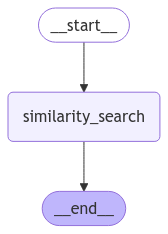

In [21]:
sim_builder = StateGraph(GraphState)
sim_builder.add_node("similarity_search", similarity_search)  # similarity_search

sim_builder.add_edge(START, "similarity_search")
sim_builder.add_edge("similarity_search", END)

graph = sim_builder.compile()
display(Image(graph.get_graph().draw_mermaid_png()))

In [ ]:
question = 'similarity search for the main function of the "noon report" in "iss" system'
result = app_stream(question=question, recursion_limit=5)
result

### Web Search - Tavily

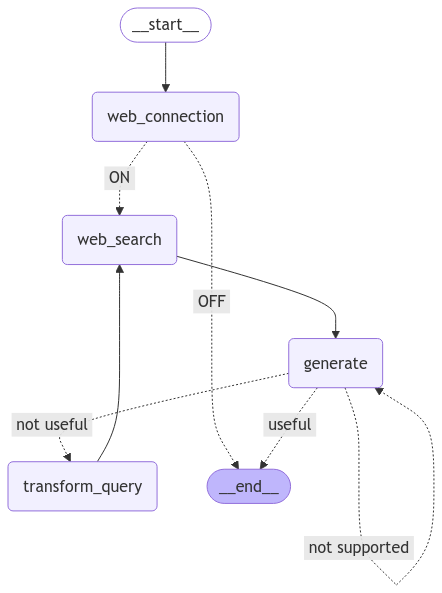

In [68]:
web_builder = StateGraph(GraphState)
web_builder.add_node("web_connection", web_connection)
web_builder.add_node("web_search", web_search)
web_builder.add_node("generate", generate)
web_builder.add_node("transform_query", transform_query)

web_builder.add_edge(START, "web_connection")
web_builder.add_conditional_edges(
    "web_connection",
    check_internet,
    {
        "ON": "web_search",
        "OFF": END,
    },
)
web_builder.add_edge("web_search", "generate")
web_builder.add_conditional_edges(
    "generate",
    grade_generation_v_documents_and_question,
    {
        "not supported": "generate",
        "useful": END,
        "not useful": "transform_query",
    },
)
web_builder.add_edge("transform_query", "web_search")

graph = web_builder.compile()
display(Image(graph.get_graph().draw_mermaid_png()))

In [69]:
question = "Check today's weather condition of Seoul"
result = app_stream(question=question, recursion_limit=5)
result

---WEB CONNECTION---
>>> state: {'question': "Check today's weather condition of Seoul"}
---CHECK INTERNET CONNECTION---
---CHECK INTERNET CONNECTION---
'>>> Node : web_connection'
'======================================================================'
---WEB SEARCH---
'>>> Node : web_search'
'======================================================================'
---GENERATE---
---CHECK HALLUCINATIONS---
---DECISION: GENERATION IS GROUNDED IN DOCUMENTS---
---GRADE GENERATION vs QUESTION---
---DECISION(Useful): GENERATION ADDRESSES QUESTION---
'>>> Node : generate'
'======================================================================'

{'documents': Document(metadata={}, page_content="{'location': {'name': 'Seoul', 'region': '', 'country': 'South Korea', 'lat': 37.5664, 'lon': 126.9997, 'tz_id': 'Asia/Seoul', 'localtime_epoch': 1732411273, 'localtime': '2024-11-24 10:21'}, 'current': {'last_updated_epoch': 1732410900, 'last_updated': '2024-11-24 10:15', 'temp_c': 7.1, 'temp_f': 44.8

{'question': "Check today's weather condition of Seoul",
 'generation': "Based on the provided context, the current weather condition in Seoul is as follows:\n\n- Location: Seoul, South Korea\n- Date: November 24, 2024\n- Time: 10:21\n- Temperature: 7.1°C (44.8°F)\n- Condition: Sunny\n- Wind speed: 3.6 km/h (2.2 mph)\n- Wind direction: East-Northeast (ENE)\n- Pressure: 1031.0 mbar (30.45 inHg)\n- Humidity: 70%\n- Cloud cover: 0%\n- Precipitation: 0.0 mm (0.0 in)\n- Visibility: 10.0 km (6.0 miles)\n- UV index: 1.0\n\nPlease note that the provided context does not include a detailed 14-day forecast for Seoul in November 2024. However, it does provide general information about the weather in Seoul in November, including:\n\n- Average temperature: 7°C to 12°C (44.6°F to 53.6°F)\n- Average rainy days: 4 days\n- Average snowy days: 2 days\n- Average temperature at the beginning of November: 18.4°C (65.1°F)\n- Average temperature at the end of November: significantly colder\n\nIt's also worth

### Rag Agent

In [ ]:
rag_builder = StateGraph(GraphState)
rag_builder.add_node("retrieve", retrieve)  # retrieve
rag_builder.add_node("grade_documents", grade_documents)  # grade documents
rag_builder.add_node("generate", generate)  # generatae
rag_builder.add_node("transform_query", transform_query)  # transform_query

rag_builder.add_edge(START, "retrieve")
rag_builder.add_edge("retrieve", "grade_documents")
rag_builder.add_conditional_edges(
    "grade_documents",
    decide_to_generate,
    {
        "transform_query": "transform_query",
        "generate": "generate",
    },
)
rag_builder.add_edge("transform_query", "retrieve")
rag_builder.add_conditional_edges(
    "generate",
    grade_generation_v_documents_and_question,
    {
        "not supported": "generate",
        "useful": END,
        "not useful": "transform_query",
    },
)

graph = rag_builder.compile()
display(Image(graph.get_graph().draw_mermaid_png()))

In [ ]:
question = 'according to "iss" manual, what is the "noon report" in iss system?'
result = app_stream(question=question, recursion_limit=5)
result

### 총조립

In [ ]:
from langgraph.graph import StateGraph, START, END

workflow = StateGraph(GraphState)
workflow.add_node("retrieve", retrieve)  
workflow.add_node("check_relevance", check_relevance)
workflow.add_node("similarity_search", similarity_search)  
workflow.add_node("web_connection", web_connection)  

workflow.add_node("web_builder", web_builder.compile())
workflow.add_node("sql_builder", sql_builder.compile())
workflow.add_node("sim_builder", sim_builder.compile())
workflow.add_node("rag_builder", rag_builder.compile())

# Build graph
workflow.add_conditional_edges(
    START,
    route_question,
    {
        "web_search": "web_connection",
        "vectorstore": "retrieve",
        "similarity_search": "similarity_search",
        "database": "check_relevance"
    },
)
workflow.add_edge("web_connection", "web_builder")
workflow.add_edge("retrieve", "rag_builder")
workflow.add_edge("similarity_search", "sim_builder")
workflow.add_edge("check_relevance", "sql_builder")

app = workflow.compile()
display(Image(app.get_graph(xray=1).draw_mermaid_png()))

# App Stream

In [ ]:
# from pprint import pprint
from langgraph.errors import GraphRecursionError
%timeit
# Run
def app_stream(question:str, recursion_limit:int=10):
    inputs = {
        "question": question, 
        }
    config = {
        "recursion_limit": recursion_limit, 
        # "configurable": {"thread_id": "1"}
        }
    try:
        for output in app.stream(inputs, 
                                config, 
                                # stream_mode="debug"
                                ):
            for key, value in output.items():
                # Node
                pprint(f">>> Node : {key}")
            pprint("="*70)

        # Final generation
        print("")
        pprint(value)
    except GraphRecursionError:
        print(f"=== Recursion Error - {recursion_limit} ===")
        value = f"=== Recursion Error - {recursion_limit} ==="
    
    return value

In [ ]:
# question = 'similarity search for the main function of the "noon report" in "iss" system'
# question = 'sim search for the obligation of master of troubled vessel in "singapore" port'
# question = 'similar search for the obligation of master of troubled vessel in "singapore" port'
# question = '''
# similarity search for below paragraph.

# B 700 Owner's duties
# 701 In order to maintain valid class the classification system specifies the following to be observed by the
# owner:
# — The ship has to be competently handled in accordance with the rules.
# — The ship has to be maintained to rule standard at all times. Any conditions of class have to be carried out
# as specified.
# — The ship has to undergo prescribed periodical and renewal surveys, as well as surveys of damage, repairs,
# conversions and alterations.
# — The Society must be furnished with all information that may influence its decisions in connection with
# classification.

# '''

question = 'according to `iss` manual, what is the `noon report` in iss system?'
# question = 'according to "iss" manual, is the noon report editable?'

# question = 'with reference to "dnv" rules, explain the "noise" level of "radar" rooms.(vectorstore)'
# question = 'from the vectorstore, what is the obligation of master of troubled vessel in "singapore" port'

# question = 'according to "bv" rule in vectorstore, explain the "sloshing" analysis model test in lng vessels'

# question = 'check the "presure" of "main engine" from database'

# question = "Check today's weather condition of Seoul"
# question = "explain me the basic concept of wig ship"

# question = "from database, what is the lowest price food (name and price)"
# question = "from database, check the weather condition"


result = app_stream(question=question, recursion_limit=5)
result